# 自编码器

生成模型的作用是学习一个概率分布$P_{model}(X)$并按这个概率分布生成数据

## 1. 自动编码器(Autoencoders)
应用：1.数据去噪 2.可视化降维

作为压缩算法的特点：
1. 与数据相关程度很高，使用植物训练的自编码器用于提取动物的特征，会得到很差的结果
2. 压缩编码后的数据是有损的
<center>自动编码器</center>
<img src='image/autoencoder.jpg' height='50%' width='50%'>
上图是一个自编码器的整体架构图(出自CS231n课件)，损失函数是原图像与重构图像间的L2距离，编解码器均使用神经网络来实现

### 1.1 数据预处理

In [1]:
import os
import torch
import numpy as np
from torch import nn, optim
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

use_cuda = torch.cuda.is_available()                    # gpu可用
device = torch.device('cuda' if use_cuda else 'cpu')    # 优先使用gpu

In [2]:
# 设置超参数(Hyperparameters)
batch_size = 128
learning_rate = 1e-3
num_epochs = 20

In [3]:
# 1.读取数据及预处理
# Compose将各种预处理操作组合，ToTensor将图片处理为tensor，
# Normalize(mean, variance)正则化
data_tf = transforms.Compose([transforms.ToTensor(),                 # 数据变为tensor，范围[0,1]
                              transforms.Normalize([0.5], [0.5])])   # 缩放到[-1,1]
# 下载MNIST手写数字训练集
train_dataset = datasets.MNIST(root='./data/MNIST', train=True, transform=data_tf, download=False)
test_dataset = datasets.MNIST(root='./data/MNIST', train=False, transform=data_tf)
# 创建数据迭代器便于训练模型
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)#, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [4]:
print('1.训练数据的维度:')
print(train_dataset.train_data.shape)
print(train_dataset.train_labels.shape)
print('2.测试数据的维度:')
print(test_dataset.test_data.shape)
print(test_dataset.test_labels.shape)

1.训练数据的维度:
torch.Size([60000, 28, 28])
torch.Size([60000])
2.测试数据的维度:
torch.Size([10000, 28, 28])
torch.Size([10000])


1.0~9样本的索引: [5, 9, 3, 0, 2, 14, 51, 1, 20, 17]


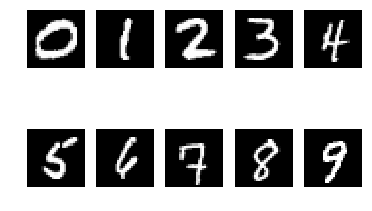

In [5]:
# 显示数据
%matplotlib inline
def show_image():
    test = test_dataset.test_labels.numpy()     # 将tensor数据转换为numpy数据
    print(np.where(test==1))
    sample_index = [np.where(test==i)[0][1] for i in range(10)] # np.where的输出(array([], dtype),)
    print('1.0~9样本的索引:', sample_index)
    sample_data = test_dataset.test_data[sample_index]          # 获取10个样本数据
    print('2.手写体样本:')
    for i in range(10):
        plt.subplot(2,5,i+1)
        sample_data = test_dataset.test_data[sample_index][i]    # torch.Size([28, 28])
#         print(sample_data.shape)
        plt.axis("off")       # 关掉坐标轴
        plt.imshow(sample_data, interpolation='none', cmap='gray')
# show_image()
def show_image2():
#     x,y = train_loader.__iter__().next()   # 通过数据迭代器访问数据
    x, y = next(train_loader.__iter__())
    x, y = map(lambda x:x.numpy(), [x, y])   # 将tensor转换为numpy数据
    sample_index = [np.where(y==i)[0][0] for i in range(10)]
    print('1.0~9样本的索引:',sample_index)
    for i in range(10):
        plt.subplot(2,5,i+1)
        sample_data = x[sample_index][i,0]    # (28,28)
        plt.axis('off')
        plt.imshow(sample_data, cmap='gray')
show_image2()

### 1.2 定义自编码器模型

In [6]:
# 定义模型
class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()                   # 继承类的初始化  
        self.encoder = nn.Sequential(        # 编码器部分 input (N, 1, 28, 28)
            nn.Linear(28*28, 128),           # (N, 128)
            nn.ReLU(),
            nn.Linear(128, 64),              # (N, 64)
            nn.ReLU(),
            nn.Linear(64, 12),               # (N, 12)
            nn.ReLU(),
            nn.Linear(12, 3)                 # (N, 3)   三个通道方便可视化
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),                # (N, 12)
            nn.ReLU(),
            nn.Linear(12, 64),               # (N, 64)
            nn.ReLU(),
            nn.Linear(64, 128),              # (N, 128)
            nn.Linear(128, 28*28),           # (N, 28*28)
            nn.Tanh()                        # 将数据缩放到 (-1,1)，与输入的数据范围对应!!!
        )
    def forward(self, x):                    # 输入数据维度    (N, 1, 28, 28)
        x_flatten = x.view(-1, 28*28)        # 将数据reshape为 (N, 28*28)
        encode = self.encoder(x_flatten)     # 编码器
        decode = self.decoder(encode)        # 解码器
        decode = decode.view(x.size())       # (N, 1, 28, 28)
        return encode, decode

### 1.3 添加损失、优化器并进行训练

In [7]:
# 设置损失函数及优化器
autoencoder = AutoEncoder().to(device)
# print(autoencoder)
criterion = nn.MSELoss()        # 均方差损失就是L2距离损失
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

In [8]:
%%time
# 开始训练模型
num_epochs = 20
pltX, pltY = [], []
epoch_end = len(train_loader) - 1
for epoch in range(num_epochs):
    print('------------Epoch:%d-------------' % epoch)
    pltX.append(epoch)
    for iteration, data in enumerate(train_loader):
        x, _ = data                               # 读入图像数据，只是用x就行
        x = x.to(device)                          # 转换数据类型
#         x = x.type(torch.cuda.FloatTensor)

        _, out = autoencoder(x)                      # (N, 28, 28)
        loss = criterion(out, x)        # 计算L2损失
#         print(loss)
        print_loss = loss.data.item()             # tensor转换为一个数
        
        # 优化模型
        optimizer.zero_grad()                     # 梯度归零
        loss.backward()                           # 反向传播
        optimizer.step()                          # 更新参数
        
        if iteration % 500 == 0 or iteration == epoch_end:
            print('Iter:{:<5} loss:{:.4f}'.format(iteration, loss.data))
    pltY.append(print_loss)

------------Epoch:0-------------
Iter:0     loss:0.9384
Iter:468   loss:0.2056
------------Epoch:1-------------
Iter:0     loss:0.2126
Iter:468   loss:0.1831
------------Epoch:2-------------
Iter:0     loss:0.1820
Iter:468   loss:0.1801
------------Epoch:3-------------
Iter:0     loss:0.1650
Iter:468   loss:0.1820
------------Epoch:4-------------
Iter:0     loss:0.1550
Iter:468   loss:0.1556
------------Epoch:5-------------
Iter:0     loss:0.1552
Iter:468   loss:0.1666
------------Epoch:6-------------
Iter:0     loss:0.1458
Iter:468   loss:0.1619
------------Epoch:7-------------
Iter:0     loss:0.1556
Iter:468   loss:0.1520
------------Epoch:8-------------
Iter:0     loss:0.1536
Iter:468   loss:0.1471
------------Epoch:9-------------
Iter:0     loss:0.1410
Iter:468   loss:0.1501
------------Epoch:10-------------
Iter:0     loss:0.1416
Iter:468   loss:0.1339
------------Epoch:11-------------
Iter:0     loss:0.1374
Iter:468   loss:0.1462
------------Epoch:12-------------
Iter:0     loss:

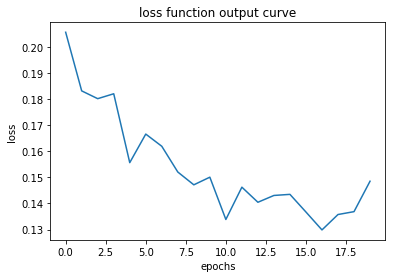

In [9]:
# 绘制loss曲线
plt.title('loss function output curve')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.plot(pltX, pltY)
plt.show()

损失函数很难看，但整体是在下降的，如果增加批次大的大小，或训练更多的epoch可以画出较平滑的图像

### 1.4 测试与评估模型

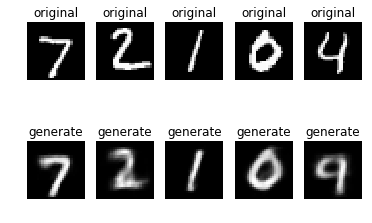

In [10]:
# 测试模型性能
autoencoder.eval()                              # 模型进入测试模式
test_x, _ = next(test_loader.__iter__())        # torch.Size([64, 1, 28, 28])
# print(test_x.shape)
test_x = test_x.to(device)
with torch.no_grad():
    _, out = autoencoder(test_x)
#     print(out.shape)
scale = lambda x:(x-x.min())/(x.max()-x.min())   # 将范围归一化到[0,1]
test_x, out = map(scale, [test_x, out])          # 将数值范围缩放到[0,1]便于显示
show_number = 5
for i in range(show_number):

    # 绘制测试的原图
    plt.subplot(2, show_number, i+1)
    plt.title('original')
    test_x_img = test_x[i,0]                     # (28,28)
    plt.axis('off')
    plt.imshow(test_x_img, cmap='gray')
    
    # 绘制生成的原图
    plt.subplot(2, show_number, show_number+i+1)
    plt.title('generate')
    out_x_img = out[i,0]
    plt.axis('off')
    plt.imshow(out_x_img, cmap='gray')

Using matplotlib backend: Qt5Agg


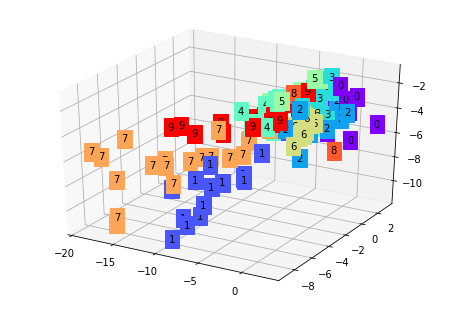

In [11]:
# 将图像显示在jupyter外，方便交互
%matplotlib      
# 将图像显示在jupyter里
# %matplotlib inline
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
autoencoder.cpu()                                  # 使用cpu处理
images, labels = next(test_loader.__iter__())      # 读入批次的数据
encode, _ = autoencoder(images)                    # encode (N,3)

fig = plt.figure()
ax = Axes3D(fig)                                   # 创建3D图
X = encode.data[:,0].numpy()                       # 创建数据点
Y = encode.data[:,1].numpy()
Z = encode.data[:,2].numpy()
values = labels.numpy()

for x, y, z, v in zip(X,Y,Z,values):
    c = cm.rainbow(int(255*v/9))                  # 画出颜色
    ax.text(x,y,z,v, backgroundcolor=c)           # 选择位置
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()

参考：[廖星宇github](https://github.com/L1aoXingyu/code-of-learn-deep-learning-with-pytorch/blob/master/chapter6_GAN/autoencoder.ipynb)

总结：
1. 解码器部分输出一定要缩放到(-1,1)范围，经过一个tanh()非线性函数处理就行

---

## 2. 基于卷积的自编码器
使用全连接层作为编码和解码器会丢失一些空间信息，导致重构的图像轮廓是模糊的，使用卷积神经网络会得到更好的效果，使轮廓更加清晰，反卷积公式：
$$out = (input-1)*s+w-2*p$$

In [8]:
# 定义基于CNN的自编码器
class AutoEncoderCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(                                # input (N, 1, 28, 28)
            nn.Conv2d(1, 16, kernel_size=3, stride=3, padding=1),    # (N,16,10,10)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),                               # (N,16,5,5)
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),    # (N,8,3,3)
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=1)                                # (N,8,2,2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2),      # (N,16,5,5)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),       # (N,8,15,15)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),        # (N,1,28,28)
            nn.Tanh()                                                # 缩放数据到 (-1,1) 
        )        
        self._init_weights()                                         # 初始化权重和偏置
        
    def forward(self, x):
        encode = self.encoder(x)
        decode = self.decoder(encode)
        return encode, decode
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                nn.init.zeros_(m.bias.data)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.ones_(m.weight.data)
                nn.init.zeros_(m.bias.data)

In [9]:
cnn_autoencoder = AutoEncoderCNN().to(device)
criterion = nn.MSELoss()         # L2损失
optimizer = optim.Adam(cnn_autoencoder.parameters(), lr=1e-3, weight_decay=1e-5)

In [10]:
%%time
# 开始训练模型
num_epochs = 25
pltX, pltY = [], []
epoch_end = len(train_loader) - 1
for epoch in range(num_epochs):
    print('------------Epoch:%d-------------' % epoch)
    for iteration, data in enumerate(train_loader):
        x, _ = data                               # 读入图像数据，只是用x就行
        x = x.to(device)                          # 转换数据类型
#         x = x.type(torch.cuda.FloatTensor)

        _, out = cnn_autoencoder(x)               # (N,1,28, 28)
        loss = criterion(out, x)                  # 计算L2损失
#         print(loss)
        print_loss = loss.data.item()             # tensor转换为一个数
        
        # 优化模型
        optimizer.zero_grad()                     # 梯度归零
        loss.backward()                           # 反向传播
        optimizer.step()                          # 更新参数
        
        if iteration % 500 == 0 or iteration == epoch_end:
#             pltX.append(epoch)
            pltY.append(print_loss)
            print('Iter:{:<5} loss:{:.4f}'.format(iteration, loss.data))
save_image(out, './image/autoencoder_sample.png')
torch.save(cnn_autoencoder, './model/autoencoder.pth')

------------Epoch:0-------------
Iter:0     loss:0.9591
Iter:468   loss:0.2769
------------Epoch:1-------------
Iter:0     loss:0.2664
Iter:468   loss:0.1584
------------Epoch:2-------------
Iter:0     loss:0.1565
Iter:468   loss:0.1298
------------Epoch:3-------------
Iter:0     loss:0.1288
Iter:468   loss:0.1259
------------Epoch:4-------------
Iter:0     loss:0.1131
Iter:468   loss:0.1213
------------Epoch:5-------------
Iter:0     loss:0.1151
Iter:468   loss:0.1003
------------Epoch:6-------------
Iter:0     loss:0.1081
Iter:468   loss:0.1010
------------Epoch:7-------------
Iter:0     loss:0.1113
Iter:468   loss:0.1019
------------Epoch:8-------------
Iter:0     loss:0.1155
Iter:468   loss:0.1020
------------Epoch:9-------------
Iter:0     loss:0.0990
Iter:468   loss:0.1047
------------Epoch:10-------------
Iter:0     loss:0.1054
Iter:468   loss:0.0942
------------Epoch:11-------------
Iter:0     loss:0.0970
Iter:468   loss:0.0988
------------Epoch:12-------------
Iter:0     loss:

D:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:241: UserWarning: Couldn't retrieve source code for container of type AutoEncoderCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


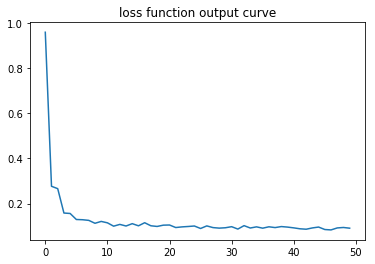

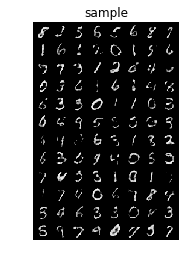

In [11]:
# 绘制loss曲线
import imageio        # 读取图像
plt.title('loss function output curve')
plt.plot(pltY)        # 每500个迭代记录一次loss
plt.show()
img = imageio.imread('./image/autoencoder_sample.png')       # (H,W,C)
plt.title('sample')
plt.axis('off')
plt.imshow(img)
plt.show()

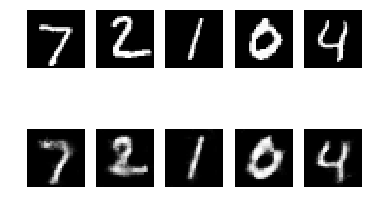

In [12]:
# 测试模型性能
cnn_autoencoder.eval()                          # 模型进入测试模式
test_x, _ = next(test_loader.__iter__())        # torch.Size([64, 1, 28, 28])
# print(test_x.shape)
test_x = test_x.to(device)
with torch.no_grad():
    _, out = cnn_autoencoder(test_x)
#     print(out.shape)
scale = lambda x:(x-x.min())/(x.max()-x.min())   # 将范围归一化到[0,1]
test_x, out = map(scale, [test_x, out])          # 将数值范围缩放到[0,1]便于显示
show_number = 5
for i in range(show_number):

    # 绘制测试的原图
    plt.subplot(2, show_number, i+1)
#     plt.title('original')
    test_x_img = test_x[i,0]                     # (28,28)
    plt.axis('off')
    plt.imshow(test_x_img, cmap='gray')
    
    # 绘制生成的原图
    plt.subplot(2, show_number, show_number+i+1)
#     plt.title('generate')
    out_x_img = out[i,0]
    plt.axis('off')
    plt.imshow(out_x_img, cmap='gray')

In [13]:
test_iter = test_loader.__iter__()

In [14]:
# 导入自编码器的模型
autoencoder = torch.load('./model/autoencoder.pth').cpu()                 # 导入模型
# 为了增加样本个数，多产生几个批次的特征
numbers = 2
X_cat, Y_cat = [], []
for i in range(numbers):
    images, labels = next(test_iter)                                      # (N,1,28,28)
    encode, decode = autoencoder(images)
    X_cat.append(encode)
    Y_cat.append(labels)

X_cat, Y_cat = map(lambda x:torch.cat(x, dim=0).clone(), [X_cat, Y_cat])   # 注意使用clone
print('1.编码器的输出维度：', X_cat.shape)
print('2.解码器的输出维度：', Y_cat.shape)

1.编码器的输出维度： torch.Size([256, 8, 2, 2])
2.解码器的输出维度： torch.Size([256])


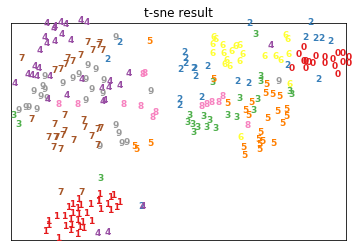

In [19]:
%matplotlib inline
from sklearn.manifold import TSNE
# 使用t-sne可视化数据
tsne = TSNE(n_components=2, init='pca', random_state=0)
X = tsne.fit_transform(X_cat.data.numpy().reshape(X_cat.shape[0],-1))   # (N, 2) 降维到2维
# X = tsne.fit_transform(images.numpy().reshape(128,-1))

x_min, x_max = np.min(X, 0), np.max(X, 0)           # 取每列的最大值与最小值
X = (X - x_min) / (x_max - x_min)                   # 对数据进行归一化才能更好的可视化
plt.figure()
ax = plt.subplot(111)
if not isinstance(Y_cat, np.ndarray):
    Y = Y_cat.numpy()
for i in range(X.shape[0]): 
#     plt.axis('off')
    plt.title('t-sne result')
    plt.xticks([])
    plt.yticks([])
    plt.text(X[i,0],X[i,1], str(Y[i]),
            color=plt.cm.Set1(Y[i]/10.),
            fontdict={'weight':'bold', 'size':9})    

总结
1. 每个样本的损失为 $\ell(x, y) = L = \{l_1,\dots,l_N\}^\top, \quad
    l_n = \left( x_n - y_n \right)^2$，一般**MSE损失**是将各批次的损失取平均即    
$$\ell = \frac{1}{N}\sum_{i=1}^N(x_i - y_i)^2$$    
使用`nn.MSELoss()`可以实现上述公式(默认)

2. **L2损失**公式：
$$\ell =\|x-y\|^2 = \sum_{i=1}^N(x_i - y_i)^2$$
使用`nn.MSELoss(reduction='sum')`表示没有除以N的操作，直接将该批次中各数据的损失$(x_i - y_i)^2$累加，实际中一般会**除以2**，在计算梯度的时候可以使系数变为1，参考[tensorflow l2_loss](https://www.tensorflow.org/api_docs/python/tf/nn/l2_loss)
3. 损失函数输出的标量值大小与回传的梯度大小有关，所以最后的损失与学习率乘积的结果回传后可以有效的更新权重，在SGD中损失函数大小可能影响比较大，但Adam算法中有归一化梯度的过程，所以损失值的大小对算法影响较小
4. 在使用`torch.load('save_model.pth')`时该文件中必须有实现了该模型的类，否则会报错AttributeError: Can’t get attribute ‘model_name’ on <module ‘main’>